In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import cftime 
import psutil
import xesmf as xe

In [3]:
import dask
from dask.diagnostics import ProgressBar

In [4]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics import visualize

In [25]:
from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

## Regrid

In [26]:
url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
raw_cat = intake.open_esm_datastore(url)

In [27]:
cat = raw_cat.search(
    experiment_id=['ssp585'],
    variable_id= 'tas',
    table_id = 'day',
    source_id = 'EC-Earth3'
)

In [28]:
cat

In [41]:
dset = cat.to_dataset_dict(zarr_kwargs={'consolidated':True}, storage_options={"anon": True}, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [34]:
sorted(dset.keys())

['ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.day.gr']

In [36]:
dset['ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.day.gr']

<xarray.Dataset>
Dimensions:    (lat: 258, bnds: 2, lon: 512, member_id: 58, time: 31411)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    height     float64 ...
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(258, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(512, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(15706, 2), meta=np.ndarray>
  * member_id  (member_id) <U10 'r6i1p1f1' 'r9i1p1f1' ... 'r4i1p1f1' 'r3i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 128, 258, 512), meta=np.ndarray>
Attributes: (12/49)
    table_info:                         Creation Date:(09 May 2019) MD5:12745...
    sub_experiment:                     none
    history:                            2019-07-10T07:03:45Z ; CMOR rewrote d...
    parent_experiment_id:               historical
    source:                             EC-Earth3 (2019): \naerosol: none\nat...
    physics_index:                      1
    ...                                 ...
    parent_activity_id:                 CMIP
    experiment_id:                      ssp585
    mip_era:                            CMIP6
    institution_id:                     EC-Earth-Consortium
    realm:                              atmos
    intake_esm_dataset_key:             ScenarioMIP.EC-Earth-Consortium.EC-Ea...

In [77]:
ds1 = list(dset.values())[2].isel(time=slice(0, 10)).load()
ds2 = list(dset.values())[0].isel(time=slice(0, 10)).load()

In [78]:
ds1 = ds1.assign_coords({'member_id': ds1.variant_label}).expand_dims('member_id')
ds2 = ds2.assign_coords({'member_id': ds2.variant_label}).expand_dims('member_id')

In [79]:
ds1 = ds1.chunk({'time': 100_000, 'lon': 5, 'lat': 5, 'member_id': 1000})
ds2 = ds2.chunk({'time': 100_000, 'lon': 5, 'lat': 5, 'member_id': 1000})

In [80]:
del ds1.attrs['intake_esm_varname']
del ds2.attrs['intake_esm_varname']

In [81]:
def drop_bounds_height(ds):
        
        """Drop coordinates like 'time_bounds' from datasets,
        which can lead to issues when merging."""
        drop_vars = [vname for vname in ds.coords
                if (('_bounds') in vname ) or ('_bnds') in vname or ('height') in vname]
        return ds.drop(drop_vars)

In [82]:
ds1 = drop_bounds_height(ds1)
ds2 = drop_bounds_height(ds2)

In [83]:
ds1

<xarray.Dataset>
Dimensions:    (lat: 256, lon: 512, member_id: 1, time: 10)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-01-10T12:00:00
  * member_id  (member_id) <U10 'r126i1p1f1'
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 10, 5, 5), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    ...                      ...
    tracking_id:             hdl:21.14100/9ad4c13a-69f3-4dee-a0fe-aec5c19ecbe...
    variable_id:             tas
    variant_label:           r126i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/9ad4c13a-69f3-4dee-a0fe-aec5c19ecbe...
    version_id:              v20200412
    intake_esm_dataset_key:  ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585...

In [88]:
ds1.to_zarr('gcs://climateai_data_repository/tmp/tests/global_cmip_append_test2.zarr', consolidated=True, mode='a', append_dim='member_id')

ValueError: append_dim='member_id' does not match any existing dataset dimensions {}

In [86]:
ds2.to_zarr('gcs://climateai_data_repository/tmp/tests/global_cmip_append_test1.zarr', consolidated=True, mode='a'ds1 = ds1.assign_coords({'member_id': ds1.variant_label}).expand_dims('member_id'))

In [85]:
xr.open_zarr('gcs://climateai_data_repository/tmp/tests/global_cmip_append_test1.zarr', consolidated=True)

<xarray.Dataset>
Dimensions:    (lat: 256, lon: 512, member_id: 1, time: 10)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * member_id  (member_id) <U10 'r126i1p1f1'
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-01-10T12:00:00
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 10, 5, 5), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    ...                      ...
    table_info:              Creation Date:(09 May 2019) MD5:1d844b3662ef3f92...
    title:                   EC-Earth3 output prepared for CMIP6
    tracking_id:             hdl:21.14100/9ad4c13a-69f3-4dee-a0fe-aec5c19ecbe...
    variable_id:             tas
    variant_label:           r126i1p1f1
    version_id:              v20200412

In [87]:
xr.open_zarr('gcs://climateai_data_repository/tmp/tests/global_cmip_append_test1.zarr', consolidated=True)

<xarray.Dataset>
Dimensions:    (lat: 256, lon: 512, member_id: 2, time: 10)
Coordinates:
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * member_id  (member_id) <U10 'r126i1p1f1' 'r107i1p1f1'
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-01-10T12:00:00
Data variables:
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 10, 5, 5), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    ...                      ...
    table_info:              Creation Date:(09 May 2019) MD5:1d844b3662ef3f92...
    title:                   EC-Earth3 output prepared for CMIP6
    tracking_id:             hdl:21.14100/cb9ca6f3-3674-49ca-a33f-025bf887ea7...
    variable_id:             tas
    variant_label:           r107i1p1f1
    version_id:              v20200412

In [12]:
dx = 2.5
ds_ref = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90 + dx, 90, dx)),
        "lon": (["lon"], np.arange(0, 360, dx)),
    }
)
ds_ref

<xarray.Dataset>
Dimensions:  (lat: 71, lon: 144)
Coordinates:
  * lat      (lat) float64 -87.5 -85.0 -82.5 -80.0 -77.5 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    *empty*

In [13]:
regridder = xe.Regridder(ds, ds_ref, "bilinear", periodic=True, )

In [34]:
ds_out = regridder(ds)

/opt/conda/envs/analogs/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [35]:
ds_out

<xarray.Dataset>
Dimensions:    (time: 31411, lat: 71, lon: 144, bnds: 2)
Coordinates:
    height     float64 ...
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(15706, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float64 dask.array<chunksize=(130, 71, 144), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [39]:
ds_out = ds_out.chunk({'time': 30_000, 'lat': 5, 'lon': 5})

In [40]:
%%time
ds_out.to_zarr('gcs://climateai_data_repository/tmp/global_cmip_test.zarr' ,consolidated=True)

CPU times: user 1min 10s, sys: 26.7 s, total: 1min 36s
Wall time: 1min 7s


In [93]:
from src.global_regridding import *

In [94]:
regrid_global(2.5, 'climateai_data_repository', 'tmp/global_cmip_2.5deg', 'MIROC6', 'historical', 'tas')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/MIROC6/historical/day/tas.zarr


  0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
  2%|▏         | 1/50 [00:34<28:20, 34.71s/it]/opt/conda/envs/analogs/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
  4%|▍         | 2/50 [01:08<27:19, 34.15s/it]/opt/conda/envs/analogs/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
distributed.utils - ERROR - ('fetch', 'memory')
Traceback (most recent call last):
  File "/opt/conda/envs/analogs/li

KeyboardInterrupt: 

## load global dataset

In [2]:
import xarray as xr

In [6]:
xr.open_zarr('gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cesm_lens/ssp585/day/tas.zarr', consolidated=True)

<xarray.Dataset>
Dimensions:    (lat: 71, lon: 144, member_id: 3, time: 31390)
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) int64 1 2 3
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2100-12-31
Data variables:
    tas        (member_id, time, lat, lon) float64 dask.array<chunksize=(1, 31390, 5, 5), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.0
    NCO:                       4.4.2
    Version:                   $Name$
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    intake_esm_dataset_key:    atm.20C.daily
    ...                        ...
    nco_openmp_thread_number:  1
    regrid_method:             bilinear
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...

In [5]:
xr.open_zarr('gcs://climateai_data_repository/tmp/global_cmip_2.5deg/MIROC6/historical/day/tas.zarr', consolidated=True)

<xarray.Dataset>
Dimensions:    (lat: 71, lon: 144, member_id: 1, time: 34699)
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) <U9 'r19i1p1f1'
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
Data variables:
    tas        (member_id, time, lat, lon) float64 dask.array<chunksize=(1, 34699, 5, 5), meta=np.ndarray>
Attributes: (12/43)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    cmor_version:            3.5.0
    data_specs_version:      01.00.31
    ...                      ...
    table_id:                day
    table_info:              Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146...
    title:                   MIROC6 output prepared for CMIP6
    tracking_id:             hdl:21.14100/3056c0c2-cbff-4856-bcca-d0546da1fb4...
    variable_id:             tas
    version_id:              v20200519

## Compute extremes

In [36]:
hist = xr.open_zarr('gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cesm_lens/historical/day/tas.zarr', consolidated=True)
future = xr.open_zarr('gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cesm_lens/ssp585/day/tas.zarr', consolidated=True)

In [37]:
hist

<xarray.Dataset>
Dimensions:    (lat: 71, lon: 144, member_id: 40, time: 34675)
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
Data variables:
    tas        (member_id, time, lat, lon) float64 dask.array<chunksize=(1, 34675, 5, 5), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.0
    NCO:                       4.4.2
    Version:                   $Name$
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    intake_esm_dataset_key:    atm.20C.daily
    ...                        ...
    nco_openmp_thread_number:  1
    regrid_method:             bilinear
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...

In [38]:
future

<xarray.Dataset>
Dimensions:    (lat: 71, lon: 144, member_id: 40, time: 31390)
Coordinates:
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2100-12-31
Data variables:
    tas        (member_id, time, lat, lon) float64 dask.array<chunksize=(1, 31390, 5, 5), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.0
    NCO:                       4.4.2
    Version:                   $Name$
    important_note:            This data is part of the project 'Blind Evalua...
    initial_file:              b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-...
    intake_esm_dataset_key:    atm.20C.daily
    ...                        ...
    nco_openmp_thread_number:  1
    regrid_method:             bilinear
    revision_Id:               $Id$
    source:                    CAM
    title:                     UNSET
    topography_file:           /scratch/p/pjk/mudryk/cesm1_1_2_LENS/inputdata...

In [39]:
hist = hist['tas'].isel(lat=slice(0, 2), lon=slice(0, 2)).load()

In [40]:
q = 0.999

In [41]:
q_values = hist.quantile(q, ('time', 'member_id'))

In [42]:
q_values

<xarray.DataArray 'tas' (lat: 2, lon: 2)>
array([[250.04914845, 249.94267409],
       [251.2088547 , 250.67315824]])
Coordinates:
  * lat       (lat) float64 -87.5 -85.0
  * lon       (lon) float64 0.0 2.5
    quantile  float64 0.999

In [43]:
occ = hist > q_values

In [46]:
occ.assign_coords({'q_values': q_values})

<xarray.DataArray 'tas' (member_id: 40, time: 34675, lat: 2, lon: 2)>
array([[[[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        ...,

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]]],

...

       [[[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        ...,

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]],

        [[False, False],
         [False, False]]]])
Coordinates:
  * lat        (lat) float64 -87.5 -85.0
  * lon        (lon) float64 0.0 2.5
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
    quantile   float64 0.999
    q_values   (lat, lon) float64 250.0 249.9 251.2 250.7

In [10]:
ds

<xarray.Dataset>
Dimensions:  (lat: 71, lon: 144, member: 50, time: 60265)
Coordinates:
  * lat      (lat) float64 -87.5 -85.0 -82.5 -80.0 -77.5 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
Dimensions without coordinates: member
Data variables:
    tas      (member, time, lat, lon) float64 dask.array<chunksize=(1, 30000, 5, 5), meta=np.ndarray>
Attributes: (12/49)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   98616.0
    cmor_version:            3.4.0
    ...                      ...
    table_info:              Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146...
    title:                   MIROC6 output prepared for CMIP6
    tracking_id:             hdl:21.14100/10635705-c623-45d6-acb2-737b3a9b9e9...
    variable_id:             tas
    variant_label:           r10i1p1f1
    version_id:              v20191016

In [11]:
ds = ds.chunk({'time': -1, 'member': -1})

In [12]:
import dask

dask.config.set({"distributed.workers.memory.spill": 0.90})
dask.config.set({"distributed.workers.memory.target": 0.80})
dask.config.set({"distributed.workers.memory.terminate": 0.98})

In [13]:
cluster = dask.distributed.LocalCluster(
            n_workers=8,
            threads_per_worker=1,
#             silence_logs=logging.ERROR
)
client = dask.distributed.Client(cluster)

In [14]:
from tqdm import tqdm
def loop_over_chunks(da, f, n_chunks=4, restart_every=10):
    n_lat, n_lon = da.data.shape[2:]
    chunksize_lat, chunksize_lon = da.data.chunksize[2:]
    n_chunks_lat = (n_lat + chunksize_lat) // chunksize_lat
    n_chunks_lon = (n_lon + chunksize_lon) // chunksize_lon
    out_lat = []
    counter = 0
    pbar = tqdm(total=n_chunks_lat*((n_chunks_lon + n_chunks) // n_chunks))
    for i in range(n_chunks_lat):
        lat_start = i * chunksize_lat
        lat_end = (i + 1) * chunksize_lat
        out_lon = []
        for j in range((n_chunks_lon + n_chunks) // n_chunks):
            lon_start = j * (chunksize_lon * n_chunks)
            lon_end = (j + 1) * (chunksize_lon * n_chunks)
    #         print((lat_start, lat_end), (lon_start, lon_end))
            chunk = ds.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
            result = f(chunk).compute()
            out_lon.append(result)
            counter += 1
            pbar.update(1)
            if counter % restart_every == 0:
                client.restart()
        out_lat.append(xr.concat(out_lon, 'lon'))
    out = xr.concat(out_lat, 'lat')

In [15]:
def quantile_func(da):
    return da.quantile(0.999, ('time', 'member'))

In [17]:
with ResourceProfiler(dt=0.25) as rprof:
    qu = loop_over_chunks(ds.tas, quantile_func)
    

100%|██████████| 120/120 [23:19<00:00, 11.66s/it]


In [20]:
rprof.visualize()

Figure(id='1154', ...)

In [14]:
# %%time
# ds.isel(lat=0, lon=0).quantile(0.999, ('time', 'member')).compute()

In [15]:
# dask.config.set(scheduler='synchronous')
# dask.config.set(scheduler='threads')
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [16]:
# import ctypes

# def trim_memory() -> int:
#     libc = ctypes.CDLL("libc.so.6")
#     return libc.malloc_trim(0)

# client.run(trim_memory)

In [18]:
qu

<xarray.Dataset>
Dimensions:   (lat: 5, lon: 5)
Coordinates:
  * lat       (lat) float64 -37.5 -35.0 -32.5 -30.0 -27.5
  * lon       (lon) float64 50.0 52.5 55.0 57.5 60.0
    quantile  float64 0.999
Data variables:
    tas       (lat, lon) float64 294.7 294.6 294.4 294.4 ... 299.7 299.6 299.5

In [48]:
occ = ds > qu

In [49]:
occ = occ.resample(time='AS').mean().rolling(time=10, center=True).mean()

In [50]:
occ

<xarray.Dataset>
Dimensions:   (time: 165, lat: 5, lon: 5, member: 50)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2014-01-01
  * lat       (lat) float64 -62.5 -60.0 -57.5 -55.0 -52.5
  * lon       (lon) float64 25.0 27.5 30.0 32.5 35.0
    quantile  float64 0.999
Dimensions without coordinates: member
Data variables:
    tas       (time, member, lat, lon) float64 dask.array<chunksize=(10, 50, 5, 5), meta=np.ndarray>

In [51]:
%%time
occ.load()

CPU times: user 1.95 s, sys: 176 ms, total: 2.13 s
Wall time: 3.84 s


<xarray.Dataset>
Dimensions:   (time: 165, lat: 5, lon: 5, member: 50)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2014-01-01
  * lat       (lat) float64 -62.5 -60.0 -57.5 -55.0 -52.5
  * lon       (lon) float64 25.0 27.5 30.0 32.5 35.0
    quantile  float64 0.999
Dimensions without coordinates: member
Data variables:
    tas       (time, member, lat, lon) float64 nan nan nan nan ... nan nan nan

In [52]:
occ

<xarray.Dataset>
Dimensions:   (time: 165, lat: 5, lon: 5, member: 50)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2014-01-01
  * lat       (lat) float64 -62.5 -60.0 -57.5 -55.0 -52.5
  * lon       (lon) float64 25.0 27.5 30.0 32.5 35.0
    quantile  float64 0.999
Dimensions without coordinates: member
Data variables:
    tas       (time, member, lat, lon) float64 nan nan nan nan ... nan nan nan

In [24]:
400 * 5 / 60

33.333333333333336

In [34]:
q = ds.isel(lat=slice(0, 100), lon=slice(0, 20)).quantile(0.999, ('time', 'member'))

In [35]:
q

<xarray.Dataset>
Dimensions:   (lat: 71, lon: 20)
Coordinates:
  * lat       (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 37.5 40.0 42.5 45.0 47.5
    quantile  float64 0.999
Data variables:
    tas       (lat, lon) float64 dask.array<chunksize=(5, 5), meta=np.ndarray>

In [36]:
x = q.tas.data

In [37]:
x

dask.array<getitem, shape=(71, 20), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

In [38]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof, ProgressBar():
    x.compute()

In [39]:
visualize([prof, rprof, cprof])

Column(id='1515', ...)

## New class

In [5]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [6]:
# 'gcs://climateai_data_repository/tmp/global_cmip_2.5deg/MIROC6/historical/day/tas.zarr'

In [7]:
mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'], 'tas', 'day', 
                               lat=slice(0, 10), lon=slice(0, 10), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [15]:
mmle.compute_x(x_type='quantile_return', name='test1', load=False)

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

distributed.core - ERROR - 'tcp://127.0.0.1:44841'
Traceback (most recent call last):
  File "/opt/conda/envs/analogs/lib/python3.9/site-packages/distributed/core.py", line 575, in handle_stream
    handler(**merge(extra, msg))
  File "/opt/conda/envs/analogs/lib/python3.9/site-packages/distributed/scheduler.py", line 5321, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://127.0.0.1:44841'
distributed.utils - ERROR - 'tcp://127.0.0.1:44841'
Traceback (most recent call last):
  File "/opt/conda/envs/analogs/lib/python3.9/site-packages/distributed/utils.py", line 638, in log_errors
    yield
  File "/opt/conda/envs/analogs/lib/python3.9/site-packages/distributed/scheduler.py", line 4304, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/opt/conda/envs/analogs/lib/python3.9/site-packages/distributed/scheduler.py", line 5424, in handle_worker
    await self.handle_stream(comm=comm, extra={"worker": worker})
  File "/opt/co

In [9]:
%debug

> /opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/common.py(239)__getattr__()
    237                 with suppress(KeyError):
    238                     return source[name]
--> 239         raise AttributeError(
    240             "{!r} object has no attribute {!r}".format(type(self).__name__, name)
    241         )



ipdb>  u


> /home/jupyter/repositories/InternalVariability/notebooks/src/multi_model_large_ensemble.py(131)compute_x()
    129                     out = self.compute_avg_stat(hist, future, stat=x_type, **kwargs)
    130                 print('Saving:', save_name)
--> 131                 out.to_zarr(save_name, consolidated=True, mode='w')
    132             x.append(out)
    133 



ipdb>  out


<xarray.DataArray 'tas' (member_id: 50, time: 181, lat: 5, lon: 5)>
array([[[[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]],

        ...,

...

        ...,

        [[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]],

        [[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, na

ipdb>  out.to_dataset(


*** SyntaxError: unexpected EOF while parsing


ipdb>  out.to_dataset()


<xarray.Dataset>
Dimensions:    (time: 181, lat: 5, lon: 5, member_id: 50)
Coordinates:
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat        (lat) float64 0.0 2.5 5.0 7.5 10.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
    quantile   float64 0.9997
    q_values   (lat, lon) float64 303.7 303.8 303.9 304.3 ... 311.5 310.5 312.0
Data variables:
    tas        (member_id, time, lat, lon) float64 nan nan nan ... nan nan nan


ipdb>  q


In [163]:
mmle.x

<xarray.DataArray 'tas' (model: 4, member_id: 50, time: 181, lat: 5, lon: 5)>
array([[[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         ...,

...

         ...,

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]]]])
Coordinates:
  * model      (model) <U13 'MIROC6' 'cesm_lens' 'CanESM5' 'MPI-ESM1-2-LR'
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat        (lat) float64 40.0 42.5 45.0 47.5 50.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0

In [164]:
mmle.results = xr.Dataset()

In [165]:
mmle.compute_LE()

/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


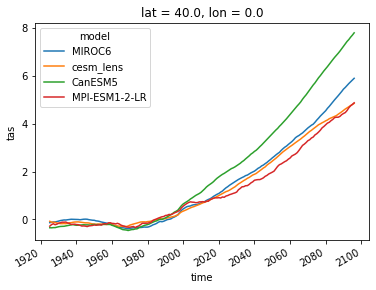

In [166]:
mmle.x.mean('member_id').isel(lat=0, lon=0).plot(hue='model')

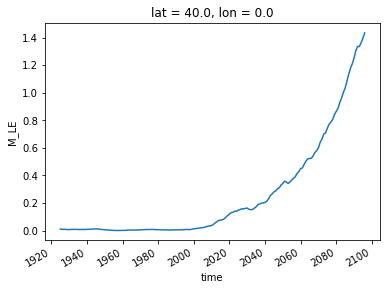

In [167]:
mmle.results['M_LE'].isel(lat=0, lon=0).plot(hue='model')

In [148]:
mmle.compute_FIT()

/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


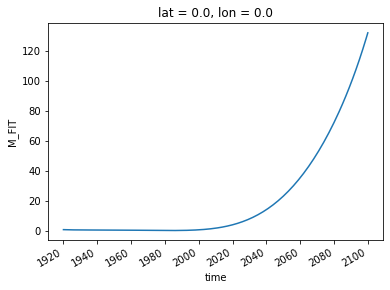

In [149]:
mmle.results['M_FIT'].isel(lat=0, lon=0).plot(hue='model')